<a href="https://colab.research.google.com/github/KhaiHuy123/identified-cancer-skin/blob/main/advanced_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_1348.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_250.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_2562.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_9789.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_4086.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_3030.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_4665.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_1161.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_3931.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_804.jpg  
  inflating: /content/data/melanoma_cancer_dataset/train/benign/melanoma_204.jpg  
  inflating: /content/data/m

In [ ]:
import torch
import torch.nn as nn
print(torch.__version__)
import os

2.1.0+cu121


In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 20.7 MB/s eta 0:00:00


In [ ]:
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as t_transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [ ]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import random
from lightning.pytorch.callbacks import ModelSummary
import os
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed()

Random seed set as 0


# Split Data

In [ ]:
benign_data_path = "/content/data/melanoma_cancer_dataset/train/benign"
malignant_data_path = "/content/data/melanoma_cancer_dataset/train/benign"
# count the number of images in each folder
benign_data_size = len(os.listdir(benign_data_path))
malignant_data_size = len(os.listdir(malignant_data_path))
print("benign_data_size: ", benign_data_size)
print("malignant_data_size: ", malignant_data_size)

benign_data_size:  5500
malignant_data_size:  5500


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Define the directories
base_dir = '/content/data/melanoma_cancer_dataset/train'
categories = ['benign', 'malignant']

# Create train, validation, and test directories
for dir_name in ['train', 'validation', 'test']:
    for category in categories:
        os.makedirs(os.path.join(dir_name, category), exist_ok=True)

# Split the data
for category in categories:
    files = os.listdir(os.path.join(base_dir, category))
    train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
    validation_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Move the files
    for file in train_files:
        shutil.move(os.path.join(base_dir, category, file), os.path.join('train', category, file))
    for file in validation_files:
        shutil.move(os.path.join(base_dir, category, file), os.path.join('validation', category, file))
    for file in test_files:
        shutil.move(os.path.join(base_dir, category, file), os.path.join('test', category, file))

- Create folders for training, validation and test files. Each folder contains 2 subfolders: benign and malignant

- files is an array containing the names of all files in the directory corresponding to the data type (benign or malignant).

- Then the array is split into sub-arrays corresponding to train test validation with a ratio of 8-1-1. (using train_test_split of sklearn library)

- From there, transfer the files from the root folder to the train test validation folders divided above.

In [ ]:
base_dir = 'data'
categories = ['benign', 'malignant']
for dir_name in ['train', 'validation', 'test']:
    for category in categories:
        num_files = len(os.listdir(os.path.join(dir_name, category)))
        print(f'There are {num_files} files in {os.path.join(dir_name, category)}')

There are 4400 files in train/benign
There are 4084 files in train/malignant
There are 550 files in validation/benign
There are 510 files in validation/malignant
There are 550 files in test/benign
There are 511 files in test/malignant


- Count files in the folders just created above

In [ ]:
transforms = t_transforms.Compose([t_transforms.Resize((224, 224)),
                                 t_transforms.ToTensor(),
                                  t_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                 ])
batch_size = 20
train_set = torchvision.datasets.ImageFolder(root='train', transform=transforms)
test_set = torchvision.datasets.ImageFolder(root='test', transform=transforms)
print(train_set.classes)
print(test_set.classes)

['benign', 'malignant']
['benign', 'malignant']


In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
train_dataiter = iter(train_loader)
train_images, train_labels = next(train_dataiter)
print(train_images.shape)

torch.Size([20, 3, 224, 224])


- import torchvision.transforms as t_transforms

- Use the method available in torchvision to create datasets from the folder containing images (torchvision.datasets.ImageFolder) and convert the image size to (224,224) digitize according to pytorch (ToTensor) then normalize (Normalize)

- Finally, use the DataLoader of torch.ultils.data to return the DataLoader object with the given batch_size

In [ ]:
def imshow(img):
    img = F.normalize(img, mean=(-0.485/0.229, -0.456/0.224, -0.406/0.225), std=(1/0.229, 1/0.224, 1/0.225))  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

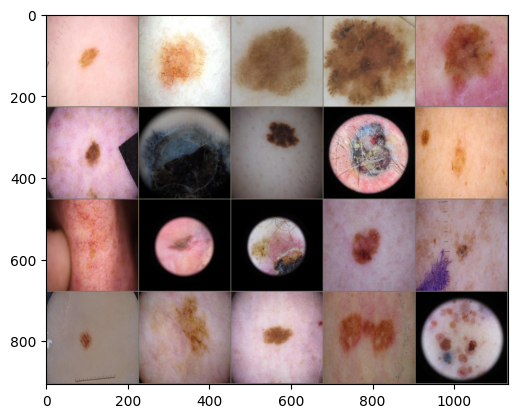

Labels: tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1])


In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images, nrow = 5))
print("Labels:", labels)


- Plot sample images in train_loader

# Define DataModule

In [ ]:
class DataModule(L.LightningDataModule):
    def __init__(self, batch_size, num_workers, train_path, val_path,test_path):
        super(DataModule, self).__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_transforms = t_transforms.Compose(
            [
                t_transforms.Resize((224, 224)),
                t_transforms.RandomHorizontalFlip(),
                t_transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                t_transforms.ToTensor(),
                t_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ]
        )
        self.test_transforms = t_transforms.Compose(
            [
                t_transforms.Resize((224, 224)),
                t_transforms.ToTensor(),
                t_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ]
        )
    transforms = t_transforms.Compose([t_transforms.Resize((224, 224)),
                                 t_transforms.ToTensor(),
                                 t_transforms.Normalize((0.5,), (0.5,))])

    def setup(self, stage=None):
        self.train_dataset = torchvision.datasets.ImageFolder(root=self.train_path, transform=self.train_transforms)
        self.val_dataset = torchvision.datasets.ImageFolder(root=self.val_path, transform=self.test_transforms)
        self.test_dataset = torchvision.datasets.ImageFolder(root=self.test_path, transform=self.test_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)



Create a DataModule that inherits from Ligthning's LightningDataModule to create a Module that can be directly inserted into Lightning's trainer with 3 distinct data_loaders: train, validation and test.

The DataModule object receives the following parameters:

- batch_size: size of 1 batch

- num_workers: number of workers used to load data

- train_path: path to the directory containing train data

- val_path: path to the directory containing validation data

- test_path: path to the directory containing test data

- train_transforms: transforms are used for preparing data suitable for the model training process, data normalization and data augmentation (augmentation).

- setup() method: prepare data before starting the training process, create datasets classes in advance to use for creating data_loaders.

- methods train_dataloader(), val_dataloader(), test_dataloader(): return data_loaders corresponding to train, validation and test.               

# Using Pytorch Module (provided) :

### Using VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3

        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)

# Define a LightningModule using the custom VGG16
class CustomVGG16(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super(CustomVGG16, self).__init__()
        self.model = VGG16(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

1)

Initializing the VGG16 layer from nn.Module (torch neuralnetwork) to create a VGG16 network that can be used in the training process includes two main parts: feature and classifier.

- feature: is the feature extraction of the VGG16 network, initialized from the Conv2d, MaxPool2d, ReLU layers and created through the make_layers() method.

- classifier: is an additional classifier after VGG16, initialized from the Linear, ReLU, Dropout and Softmax classes.

- forward() method: performs the forward propagation process of the VGG16 network. Then the input will be passed through the feature part to extract features and then passed through the classifier part for classification (ie prediction).

class CustomVGG16(L.LightningModule):
The CustomVGG16 class inherits from Lightning's LightningModule to create a Module that can be directly inserted into Lightning's trainer and can use LightningModule's methods.


2)

Initialize a VGG16 model from the above VGG16 class with a class count of 2. Then customize the LightningModule's methods to match the VGG16 model.
    
* forward() :
Carry out the forward propagation process of the VGG16 network.

* training_step() :
performs forward propagation (self.x) and returns the loss of a batch.

* validation_step() :
Similar to training_step() but during validation.

* test_step() :
Similar to training_step() but during testing.

* predict_step() :
Defines how to calculate predictions when using the model to predict on a batch of data, returning prediction results.

* configure_optimizers() :
Initialize optimizer with learning rate for VGG16 model.

    



In [ ]:
!pip install -q torchinfo

In [ ]:
# from torchsummary import summary
from torchinfo import summary

model = CustomVGG16()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomVGG16 (CustomVGG16)                [32, 3, 224, 224]    [32, 2]              --                   True
├─VGG16 (model)                          [32, 3, 224, 224]    [32, 2]              --                   True
│    └─Sequential (features)             [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    │    └─Conv2d (0)                   [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    │    └─ReLU (1)                     [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─Conv2d (2)                   [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    │    └─ReLU (3)                     [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─MaxPool2d (4)                [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    │    └─Conv2d (

- Write Log for VGG16

In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='VGG16-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGG16()
batch_size = 32

dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
dataModule.setup()

trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)

trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: cristianoronalbaydi (cristiano_ronalbaydi). Use `wandb login --relogin` to force relogin


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG16            | 134 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG16            | 134 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 266: 'val_acc' reached 0.79245 (best 0.79245), saving model to '/content/checkpoint/epoch=0-step=266.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 532: 'val_acc' reached 0.86038 (best 0.86038), saving model to '/content/checkpoint/epoch=1-step=532.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 798: 'val_acc' reached 0.89528 (best 0.89528), saving model to '/content/checkpoint/epoch=2-step=798.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1064: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1330: 'val_acc' reached 0.91698 (best 0.91698), saving model to '/content/checkpoint/epoch=4-step=1330.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1596: 'val_acc' reached 0.91981 (best 0.91981), saving model to '/content/checkpoint/epoch=5-step=1596.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1862: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2128: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2394: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2660: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9208294153213501     │
│         test_loss         │    0.19998519122600555    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19998519122600555, 'test_acc': 0.9208294153213501}]

1)

Use WandbLogger from the pytorch_lightning.loggers library to log training parameters and results to Weights & Biases (WandB).

Using Lightning Callbacks:

- ModelCheckpoint :
Save model checkpoints during training when val_acc is better than previous times.

- EarlyStopping :
Stop training when val_acc does not improve within a certain number of epochs.

- ModelSummary :
Displays model information.

2)

Create model from customVGG16 and dataModule with batch_size of 32 and num_workers of 2.

Pass the model and dataModule to Lightning's trainer to start the training process with the following parameters:

- max_epochs :
The maximum number of epochs is 10.

- callbacks :
Use the callbacks initialized above.

- logger :
Use the logger initialized above.



### Using ResNet152

In [ ]:
class Model_resnet152_full(L.LightningModule):
  def __init__(self, is_train=False, learning_rate=1e-3,
               num_target_classes=2, optimizer_type="adam", loss_type="cross_entropy"):
    super(Model_resnet152_full, self).__init__()
    backbone = torchvision.models.resnet152(weights="DEFAULT") # ------ resnet152 OK
    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]
    custom_fc = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(num_filters, 512),  # Fully connected layer with 512 output features
        torch.nn.ReLU(),  # ReLU activation
        torch.nn.Dropout(0.5),  # Dropout layer
        torch.nn.Linear(512, num_target_classes)  # Fully connected layer with num_target_classes output
    )
    self.fc = custom_fc
    self.feature_extractor = torch.nn.Sequential(*layers)
    self.classifier = torch.nn.Linear(num_filters, num_target_classes)
    self.is_train = is_train
    self.learning_rate = learning_rate

    # define optimizer
    if optimizer_type == "adam":
        self.optimizer_name = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    elif optimizer_type == "sgd":
        self.optimizer_name = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
    else: raise ValueError("Invalid optimizer type.")

    # define loss function
    if loss_type == "cross_entropy":
        self.loss = torch.nn.CrossEntropyLoss()
    elif loss_type == "mse":
        self.loss = torch.nn.MSELoss()
    else: raise ValueError("Invalid loss function type")

    #define accuracy metrics
    self.accuracy = torchmetrics.classification.Accuracy(task="multiclass",
                                                         num_classes=num_target_classes)

  def configure_optimizers(self):
    return self.optimizer_name

  def compute_loss(self, y_pred, y):
    return self.loss(y_pred, y)

  def forward(self, x):
    self.feature_extractor.eval()
    if self.is_train:
      representations = self.feature_extractor(x).flatten(1)
    else:
      with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def training_step(self, batch, batch_idx):
    x, y = batch[0], batch[1]
    y_pred = self(x)
    train_loss = self.compute_loss(y_pred, y)
    acc = self.accuracy(y_pred, y)
    self.log_dict({'train_loss': train_loss, 'train_acc': acc} , prog_bar=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch[0], batch[1]
    y_pred = self(x)
    val_loss = self.compute_loss(y_pred, y)
    val_acc = self.accuracy(y_pred, y)
    self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch[0], batch[1]
    y_pred = self(x)
    test_loss = self.compute_loss(y_pred, y)
    test_acc = self.accuracy(y_pred, y)
    self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
    return test_loss

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
    x = batch[0]
    with torch.no_grad():
        predictions = self.forward(x)
    predicted_probs = torch.softmax(predictions, dim=1)
    predicted_labels = predicted_probs.argmax(dim=1)
    return {"probs": predicted_probs, "labels": predicted_labels}


model = Model_resnet152_full()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
Model_resnet152_full (Model_resnet152_full)   [32, 3, 224, 224]    [32, 2]              1,050,114            True
├─Sequential (feature_extractor)              [32, 3, 224, 224]    [32, 2048, 1, 1]     --                   True
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]   

- Write Log for ResNet152

In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='ResNet152-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = Model_resnet152_full()
batch_size = 32

dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
dataModule.setup()

trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)

trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | fc                | Sequential         | 1.1 M 
1 | feature_extractor | Sequential         | 58.1 M
2 | classifier        | Linear             | 4.1 K 
3 | loss              | CrossEntropyLoss   | 0     


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 266: 'val_acc' reached 0.90755 (best 0.90755), saving model to '/content/checkpoint/epoch=0-step=266-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 532: 'val_acc' reached 0.91038 (best 0.91038), saving model to '/content/checkpoint/epoch=1-step=532.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 798: 'val_acc' reached 0.91887 (best 0.91887), saving model to '/content/checkpoint/epoch=2-step=798.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1064: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1330: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1596: 'val_acc' reached 0.92264 (best 0.92264), saving model to '/content/checkpoint/epoch=5-step=1596.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1862: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2128: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2394: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2660: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9274269342422485     │
│         test_loss         │    0.19613176584243774    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19613176584243774, 'test_acc': 0.9274269342422485}]

### Using EficientNet

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

- Write Log for EfficietnNet

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ca55c47f33a0cf5c5dd7b34ea65c061b3b05d0d436bcc0f8cf5fb2246d9094e6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EfficientNet, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b7')
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)
from efficientnet_pytorch import EfficientNet
class CustomEfficientNet(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super(CustomEfficientNet, self).__init__()
        self.model =  EfficientNet.from_pretrained('efficientnet-b7')
        in_features = self.model._fc.in_features
        self.model._fc = nn.Linear(in_features, num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


model = CustomEfficientNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:02<00:00, 92.4MB/s]


Loaded pretrained weights for efficientnet-b7


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
CustomEfficientNet (CustomEfficientNet)                           [32, 3, 224, 224]    [32, 2]              --                   True
├─EfficientNet (model)                                            [32, 3, 224, 224]    [32, 2]              --                   True
│    └─Conv2dStaticSamePadding (_conv_stem)                       [32, 3, 224, 224]    [32, 64, 112, 112]   1,728                True
│    │    └─ZeroPad2d (static_padding)                            [32, 3, 224, 224]    [32, 3, 225, 225]    --                   --
│    └─BatchNorm2d (_bn0)                                         [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─MemoryEfficientSwish (_swish)                              [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─ModuleList (_blocks)                                  

Initialize the EfficientNet class from nn.Module (torch neuralnetwork) to create an EfficientNet network that can be used during the training process, consisting of two main parts: feature and classifier.

- feature: is the feature extraction of the VGG16 network, initialized from the Conv2d, MaxPool2d, ReLU layers and created through the make_layers() method.
classifier: is an additional classifier after VGG16, initialized from the Linear, ReLU, Dropout and Softmax classes.

- forward() method: performs the forward propagation process of the VGG16 network. Then the input will be passed through the feature part to extract features and then passed through the classifier part for classification (ie prediction).

- class CustomEfficientNet(L.LightningModule):
The CustomEfficientNet class inherits from Lightning's LightningModule to create a Module that can be directly inserted into Lightning's trainer and can use LightningModule's methods.

    



In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='EfficientNet-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=2)]

model = CustomEfficientNet()
batch_size = 32
dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)

trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded pretrained weights for efficientnet-b7


INFO: 
   | Name               | Type                    | Params
----------------------------------------------------------------
0  | model              | EfficientNet            | 63.8 M
1  | model._conv_stem   | Conv2dStaticSamePadding | 1.7 K 
2  | model._bn0         | BatchNorm2d             | 128   
3  | model._blocks      | ModuleList              | 62.1 M
4  | model._conv_head   | Conv2dStaticSamePadding | 1.6 M 
5  | model._bn1         | BatchNorm2d             | 5.1 K 
6  | model._avg_pooling | AdaptiveAvgPool2d       | 0     
7  | model._dropout     | Dropout                 | 0     
8  | model._fc          | Linear                  | 5.1 K 
9  | model._swish       | MemoryEfficientSwish    | 0     
10 | loss               | CrossEntropyLoss        | 0     
----------------------------------------------------------------
63.8 M    Trainable params
0         Non-trainable params
63.8 M    Total params
255.168   Total estimated model params size (MB)
INFO:lightning.pytorch.ca

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 531: 'val_acc' reached 0.93868 (best 0.93868), saving model to '/content/checkpoint/epoch=0-step=531.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1062: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1593: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2124: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2655: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 3186: 'val_acc' was not in top 1


If you use EfficientNet, it is similar to the trainer for VGG16 but the batch_size is 16. This shows that using EfficientNet will cost less (smaller bacth instead of using batch = 32).

Explaining EfficientNet can say some important things as follows:

- The main point of EfficientNet is to solve the challenge of model scaling (proportionality between model complexity and computational and storage costs).
- Avoid increasing computational and memory costs when increasing depth, width and resolution.

Compare with other architectures such as ResNet50, ResNet152, AlexNet, VGG16 and VGG19. (Here we choose VGG16 to do)

- EfficientNet usually has a smaller number of parameters than large architectures like ResNet152 for example.
- EfficientNet is designed with fewer FLOPs (floating-point operations per second) than other architectures.


In [ ]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9415645599365234     │
│         test_loss         │    0.2786484360694885     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2786484360694885, 'test_acc': 0.9415645599365234}]

### Using MobileNet

In addition to EfficientNet, you can also use MobileNet. We will check to see if using MobileNet can cost less.

In [ ]:
import torch.nn as nn
import torchvision.models as models

class MobileNet(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2()
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

class CustomMobileNet(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4, optimizer_type="adam", loss_type ="cross_entropy"):
        super(CustomMobileNet, self).__init__()
        self.model = MobileNet(num_classes=num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

        # define optimizer
        if optimizer_type == "adam":
            self.optimizer_name = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif optimizer_type == "sgd":
            self.optimizer_name = torch.optim.SGD(self.parameters(), lr=self.lr)
        else: raise ValueError("Invalid optimizer type.")

        # define loss function
        if loss_type == "cross_entropy":
            self.loss = torch.nn.CrossEntropyLoss()
        elif loss_type == "mse":
            self.loss = torch.nn.MSELoss()
        else: raise ValueError("Invalid loss function type")

        #define accuracy metrics
        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass",
                                                            num_classes=num_classes)

    def configure_optimizers(self):
        return self.optimizer_name

    def compute_loss(self, y_pred, y):
        return self.loss(y_pred, y)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      train_loss = self.compute_loss(y_pred, y)
      acc = self.accuracy(y_pred, y)
      self.log_dict({'train_loss': train_loss, 'train_acc': acc} , prog_bar=True)
      return train_loss

    def validation_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      val_loss = self.compute_loss(y_pred, y)
      val_acc = self.accuracy(y_pred, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      test_loss = self.compute_loss(y_pred, y)
      test_acc = self.accuracy(y_pred, y)
      self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
      x = batch[0]
      with torch.no_grad():
          predictions = self.forward(x)
      predicted_probs = torch.softmax(predictions, dim=1)
      predicted_labels = predicted_probs.argmax(dim=1)
      return {"probs": predicted_probs, "labels": predicted_labels}

model = CustomMobileNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CustomMobileNet (CustomMobileNet)                       [32, 3, 224, 224]    [32, 2]              --                   True
├─MobileNet (model)                                     [32, 3, 224, 224]    [32, 2]              --                   True
│    └─MobileNetV2 (model)                              [32, 3, 224, 224]    [32, 2]              --                   True
│    │    └─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     2,223,872            True
│    │    └─Sequential (classifier)                     [32, 1280]           [32, 2]              2,562                True
Total params: 2,226,434
Trainable params: 2,226,434
Non-trainable params: 0
Total mult-adds (G): 9.58
Input size (MB): 19.27
Forward/backward pass size (MB): 3419.19
Params size (MB): 8.91
Estimated Total Size (MB): 3447.37

In [ ]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(name='MobileNet-skinCancer', project='MLA_skinCancer')

model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=2)]

model = CustomMobileNet()
batch_size=32

dataModule = DataModule(batch_size=batch_size, num_workers=2, train_path='train', val_path='validation',test_path='test')
dataModule.setup()

In [ ]:
trainer = L.Trainer(max_epochs=10,callbacks=callbacks,logger=wandb_logger)
trainer.fit(model, dataModule)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params
---------------------------------------------------
0 | model       | MobileNet          | 2.2 M 
1 | model.model | MobileNetV2        | 2.2 M 
2 | loss        | CrossEntropyLoss   | 0     
3 | accuracy    | MulticlassAccuracy | 0     
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 266: 'val_acc' reached 0.84340 (best 0.84340), saving model to '/content/checkpoint/epoch=0-step=266.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 532: 'val_acc' reached 0.85660 (best 0.85660), saving model to '/content/checkpoint/epoch=1-step=532.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 798: 'val_acc' reached 0.86981 (best 0.86981), saving model to '/content/checkpoint/epoch=2-step=798.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1064: 'val_acc' reached 0.88208 (best 0.88208), saving model to '/content/checkpoint/epoch=3-step=1064.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1330: 'val_acc' reached 0.88679 (best 0.88679), saving model to '/content/checkpoint/epoch=4-step=1330.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1596: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1862: 'val_acc' reached 0.89057 (best 0.89057), saving model to '/content/checkpoint/epoch=6-step=1862.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2128: 'val_acc' reached 0.89245 (best 0.89245), saving model to '/content/checkpoint/epoch=7-step=2128.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2394: 'val_acc' reached 0.89340 (best 0.89340), saving model to '/content/checkpoint/epoch=8-step=2394.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2660: 'val_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.test(model, dataModule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9095193147659302     │
│         test_loss         │    0.22494232654571533    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22494232654571533, 'test_acc': 0.9095193147659302}]

### Using Inception

In [ ]:
import torch.nn as nn
import torchvision.models as models

class InceptionNet(nn.Module):
    def __init__(self, num_classes=2):
        super(InceptionNet, self).__init__()
        self.model = models.inception_v3(init_weights=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

class CustomInceptionNet(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-4, optimizer_type="adam", loss_type ="cross_entropy"):
        super(CustomInceptionNet, self).__init__()
        self.model = InceptionNet(num_classes=num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

        # define optimizer
        if optimizer_type == "adam":
            self.optimizer_name = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif optimizer_type == "sgd":
            self.optimizer_name = torch.optim.SGD(self.parameters(), lr=self.lr)
        else: raise ValueError("Invalid optimizer type.")

        # define loss function
        if loss_type == "cross_entropy":
            self.loss = torch.nn.CrossEntropyLoss()
        elif loss_type == "mse":
            self.loss = torch.nn.MSELoss()
        else: raise ValueError("Invalid loss function type")

        #define accuracy metrics
        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass",
                                                            num_classes=num_classes)

    def configure_optimizers(self):
        return self.optimizer_name

    def compute_loss(self, y_pred, y):
        return self.loss(y_pred, y)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      train_loss = self.compute_loss(y_pred, y)
      acc = self.accuracy(y_pred, y)
      self.log_dict({'train_loss': train_loss, 'train_acc': acc} , prog_bar=True)
      return train_loss

    def validation_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      val_loss = self.compute_loss(y_pred, y)
      val_acc = self.accuracy(y_pred, y)
      self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
      return val_loss

    def test_step(self, batch, batch_idx):
      x, y = batch[0], batch[1]
      y_pred = self(x)
      test_loss = self.compute_loss(y_pred, y)
      test_acc = self.accuracy(y_pred, y)
      self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
      return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
      x = batch[0]
      with torch.no_grad():
          predictions = self.forward(x)
      predicted_probs = torch.softmax(predictions, dim=1)
      predicted_labels = predicted_probs.argmax(dim=1)
      return {"probs": predicted_probs, "labels": predicted_labels}

model = CustomInceptionNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
CustomInceptionNet (CustomInceptionNet)            [32, 3, 224, 224]    [32, 2]              --                   True
├─InceptionNet (model)                             [32, 3, 224, 224]    [32, 2]              --                   True
│    └─Inception3 (model)                          [32, 3, 224, 224]    [32, 2]              3,326,696            True
│    │    └─BasicConv2d (Conv2d_1a_3x3)            [32, 3, 224, 224]    [32, 32, 111, 111]   928                  True
│    │    └─BasicConv2d (Conv2d_2a_3x3)            [32, 32, 111, 111]   [32, 32, 109, 109]   9,280                True
│    │    └─BasicConv2d (Conv2d_2b_3x3)            [32, 32, 109, 109]   [32, 64, 109, 109]   18,560               True
│    │    └─MaxPool2d (maxpool1)                   [32, 64, 109, 109]   [32, 64, 54, 54]     --                   --
│    │    └─BasicConv2d (Conv2d_3b_1x1)      